In [5]:
import pandas as pd
import json_handling as jh
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [6]:
folder_path = 'aob_2025/orders'

all_data = jh.load_json_objects_from_folder(folder_path)
print(f"Loaded {len(all_data)} JSON objects from {folder_path}")

dfs = jh.extract_dataframes(all_data)
    

Loaded 43800 JSON objects from aob_2025/orders


In [7]:
df_orders = dfs['orders']
df_payment_details = dfs['payment_details']
df_orderlines = dfs['orderlines']
df_shown_addons = dfs['shown_addons']
df_search_data = dfs['search_data']
df_search_orders = dfs['search_orders']
df_search_parameters = dfs['search_parameters']


In [8]:
df_search_orders

,parent_order_id,search_order_key,order_id,order_type,user_ipaddress,paid,paid_at,paid_at_date,paid_transact,cancelled,...,booking_type,type,timestamp,logreader_type,orderlines,shown_addons,variants,pr,pr_type,segtypes
0,1951660,1,1951660,air,91.32.25.144,True,1735306785,2024-12-27T14:39:45+01:00,smNO7I2VWhoYUV/tMTLNYK5hKdM=,False,...,"{'ndc': 1, 'lcc': 1, 'reg': 0}",order,1735306509,order,"{'air': {'product_code': 'air', 'orderline_typ...","{'KK': 15, 'AVB': 84, 'SMS': 3, 'VIP': 24, 'NO...",{'AVB First test_control': ''},336960.0,metas,NaN
1,1951669,1,1951668,air,194.230.144.96,False,0,None,None,False,...,"{'ndc': 0, 'lcc': 0, 'reg': 1}",order,1735307371,order,"{'air': {'product_code': 'air', 'orderline_typ...",None,None,336510.0,metas,NaN
2,1951669,2,1951669,air,194.230.144.96,False,0,None,None,False,...,"{'ndc': 0, 'lcc': 0, 'reg': 1}",order,1735307422,order,"{'air': {'product_code': 'air', 'orderline_typ...","{'KK': 20, 'AVB': 58, 'SMS': 5, 'VIP': 22, 'BA...",{},336510.0,metas,NaN
3,1951678,1,1951678,air,193.90.162.48,False,0,None,None,False,...,"{'ndc': 0, 'lcc': 0, 'reg': 1}",order,1735308049,order,"{'air': {'product_code': 'air', 'orderline_typ...","{'KK': 195, 'AVB': 275, 'SMS': 49, 'VIP': 125,...",{},336895.0,metas,NaN
4,1951692,1,1951692,air,213.244.61.133,True,1735310255,2024-12-27T15:37:35+01:00,1951692-1009092-6918ca,False,...,"{'ndc': 0, 'lcc': 0, 'reg': 1}",order,1735309837,order,"{'air': {'product_code': 'air', 'orderline_typ...","{'KK': 10, 'AVB': 26, 'SMS': 5, 'VIP': 11, 'NO...",{},331462.0,metas,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50665,1919294,1,1919294,air,109.43.115.161,True,1731698587,2024-11-15T20:23:07+01:00,uNnY6VLOtLqmBZraYcB4rka8fCc=,False,...,NaN,order,1731698279,order,"{'air': {'product_code': 'air', 'orderline_typ...","{'SMS': 5, 'CHECKIN': 8, 'CHANGE': 40, 'NONE':...",NaN,334816.0,flights,NaN
50666,1919343,1,1919343,air,155.4.129.13,True,1731703468,2024-11-15T21:44:28+01:00,3364a2_1919343,False,...,NaN,order,1731703380,order,"{'air': {'product_code': 'air', 'orderline_typ...","{'SMS': 49, 'CHECKIN': 79, 'AVB': 295, 'VIP': ...",NaN,336673.0,metas,NaN
50667,1919346,1,1919346,air,46.114.194.156,True,1731704130,2024-11-15T21:55:30+01:00,1919346-980243-13a109,False,...,NaN,order,1731703956,order,"{'air': {'product_code': 'air', 'orderline_typ...","{'SMS': 5, 'CHECKIN': 16, 'NONE': 0, 'VIP': 40...",NaN,331462.0,metas,NaN
50668,1919347,1,1919347,air,217.122.22.162,True,1731704134,2024-11-15T21:55:34+01:00,dc7ac6_1919347,False,...,NaN,order,1731704010,order,"{'air': {'product_code': 'air', 'orderline_typ...","{'CHECKIN': 3, 'SMS': 3, 'VIP': 12, 'BASIC': 0...",NaN,335579.0,metas,NaN


In [9]:

df_combined = df_orders.merge(
    df_payment_details[['order_id', 'cost', 'total_sales_price', 'paid_amount']],
    on='order_id',
    how='left',
    suffixes=('', '_payment')
)

df_combined = df_combined.merge(
    df_search_data,
    left_on='order_id',
    right_on='parent_order_id',
    how='left',
    suffixes=('', '_search')
)

if 'df_shown_addons' in locals():
    df_combined = df_combined.merge(
        df_shown_addons,
        on='order_id',
        how='left'
    )

if 'mobile' in df_combined.columns:
    df_combined['mobile'] = df_combined['mobile'].astype(bool)

def count_itinerary_legs(itinerary):
    if pd.isna(itinerary) or itinerary == '':
        return 0
    
    if isinstance(itinerary, str):
        if ',' in itinerary:
            # Format: "FRA-LON, LON-AGP, AGP-FRA"
            return len(itinerary.split(','))
        elif '-' in itinerary:
            # Format: "FRA-LON-AGP-FRA"
            segments = itinerary.split('-')
            return len(segments) - 1 if len(segments) > 1 else 0
    
    return 0

if 'itinerary_string' in df_combined.columns:
    df_combined['num_legs'] = df_combined['itinerary_string'].apply(count_itinerary_legs)

if 'df_search_parameters' in locals():
    if 'rooms' in df_search_parameters.columns:
        df_search_parameters['num_rooms'] = df_search_parameters['rooms'].apply(
            lambda x: len(x) if isinstance(x, list) else 0
        )
    else:
        df_search_parameters['num_rooms'] = 0
    
    df_search_parameters['adults'] = pd.to_numeric(
        df_search_parameters.get('adults', 0), errors='coerce'
    ).fillna(0)
    
    df_search_parameters['children'] = pd.to_numeric(
        df_search_parameters.get('children', 0), errors='coerce'
    ).fillna(0)
    
    param_cols = ['parent_order_id']
    if 'num_rooms' in df_search_parameters.columns:
        param_cols.append('num_rooms')
    if 'adults' in df_search_parameters.columns:
        param_cols.append('adults')
    if 'children' in df_search_parameters.columns:
        param_cols.append('children')
    if 'leg_0_origin_continent' in df_search_parameters.columns:
        param_cols.append('leg_0_origin_continent')
    if 'leg_0_destination_continent' in df_search_parameters.columns:
        param_cols.append('leg_0_destination_continent')
    
    if len(param_cols) > 1:
        df_combined = df_combined.merge(
            df_search_parameters[param_cols],
            left_on='order_id',
            right_on='parent_order_id',
            how='left',
            suffixes=('', '_params')
        )

df_orderlines_numeric = df_orderlines.copy()
for col in ['qty', 'profit', 'price', 'cost']:
    if col in df_orderlines_numeric.columns:
        df_orderlines_numeric[col] = pd.to_numeric(df_orderlines_numeric[col], errors='coerce')

def categorize_seat(product_code):
    if not isinstance(product_code, str):
        return product_code
    
    if product_code.startswith('seat_'):
        seat_num = product_code.split('_')[1]
        try:
            seat_num = int(seat_num)
            if 1 <= seat_num <= 15:
                return 'seat_1_15'
            elif 16 <= seat_num <= 25:
                return 'seat_16_25'
            else:  # 26+
                return 'seat_26plus'
        except ValueError:
            return product_code
    return product_code

df_orderlines_numeric[df_orderlines_numeric['product_code'] == 'SEAT2'] = 'seat_2'
df_orderlines_numeric['product_code_category'] = df_orderlines_numeric['product_code'].apply(categorize_seat)

product_pivot = df_orderlines_numeric.pivot_table(
    index='order_id',
    columns='product_code_category',
    values='qty',
    aggfunc='sum',
    fill_value=0
)

product_pivot = product_pivot.reset_index()

df_combined = df_combined.merge(
    product_pivot,
    on='order_id',
    how='left'
)

df_combined.fillna(0, inplace=True)

if 'parent_order_id_params' in df_combined.columns:
    df_combined.drop('parent_order_id_params', axis=1, inplace=True)

/var/folders/gq/50zq6n4d3vl2rcjc5w22qs5w0000gn/T/ipykernel_59004/2318995097.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'seat_2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_orderlines_numeric[df_orderlines_numeric['product_code'] == 'SEAT2'] = 'seat_2'
/var/folders/gq/50zq6n4d3vl2rcjc5w22qs5w0000gn/T/ipykernel_59004/2318995097.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'seat_2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_orderlines_numeric[df_orderlines_numeric['product_code'] == 'SEAT2'] = 'seat_2'
/var/folders/gq/50zq6n4d3vl2rcjc5w22qs5w0000gn/T/ipykernel_59004/2318995097.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 

In [ ]:
def translate_continent(name):
    mapping = {
        'Europe': 'Europe',
        'Europa': 'Europe',
        'Asia': 'Asia',
        'Asien': 'Asia',
        'North America': 'North America',
        'Nordamerika': 'North America',
        'Africa': 'Africa',
        'Afrika': 'Africa',
        'Afrikka': 'Africa',
        'South America': 'South America',
        'Sydamerika': 'South America',
        'Oceania': 'Oceania',
        'Oceanien': 'Oceania'
    }
    return mapping.get(name, name)

df_combined['leg_0_origin_continent'] = df_combined['leg_0_origin_continent'].apply(translate_continent)
df_combined['leg_0_destination_continent'] = df_combined['leg_0_destination_continent'].apply(translate_continent)

In [57]:
df_combined['leg_0_origin_continent'].value_counts()

leg_0_origin_continent
Europe           35200
Europa            5344
Asia              1477
North America      577
Africa             323
Afrika             289
South America      198
Asien              184
Oceania             88
Nordamerika         75
Oceanien            19
Afrikka             17
Sydamerika           9
Name: count, dtype: int64

In [10]:
df_combined[df_combined['gate_id'] == 144]['country'].value_counts().index[0]

'NO'

In [ ]:
exchange_rates = {'SEK': 1, 'DKK': 1.46596, 'NOK': 0.92904, 'EUR': 10.936514, 'CHF': 11.457459}

def convert_to_sek(gate_id, currency_value, exchange_rates):
    gate_currency_map = {
        'SE': [13, 14, 15, 16, 33, 37, 43, 49, 108, 55, 63, 65, 67, 75, 107, 6, 51, 132, 146, 137, 168, 173],
        'DK': [77, 81, 82, 83, 84, 105, 109, 143, 148],
        'NO': [87, 88, 89, 110, 113, 126, 144],
        'DE': [111, 112, 124, 138, 91, 145, 149, 128],
        'FI': [90, 130, 136, 159, 160],
        'NL': [101, 117, 147, 166, 170],
        'AT': [141, 151, 152, 161, 162],
        'CH': [142, 153, 154, 155, 156, 163, 164],
        'PL': [157]
    }

    currency_code = None
    for currency, gates in gate_currency_map.items():
        if gate_id in gates:
            if currency == 'SE':
                return currency_value  
            elif currency == 'DK':
                currency_code = 'DKK'
            elif currency == 'NO':
                currency_code = 'NOK'
            elif currency in ['DE', 'AT', 'FI', 'NL', 'PL']:
                currency_code = 'EUR'
            elif currency == 'CH':
                currency_code = 'CHF'
            break

    if not currency_code:
        raise ValueError(f"Unrecognized gate_id: {gate_id}")

    exchange_rate = exchange_rates.get(currency_code)
    if exchange_rate is None:
        raise ValueError(f"Exchange rate for {currency_code} not available.")

    value_in_sek = currency_value * exchange_rate
    return value_in_sek

df_combined['payment_fee'] = df_combined.apply(lambda row: convert_to_sek(row['gate_id'], row['payment_fee'], exchange_rates), axis=1)
df_combined['cost'] = df_combined.apply(lambda row: convert_to_sek(row['gate_id'], row['cost'], exchange_rates), axis=1)
df_combined['total_sales_price'] = df_combined.apply(lambda row: convert_to_sek(row['gate_id'], row['total_sales_price'], exchange_rates), axis=1)
df_combined['paid_amount'] = df_combined.apply(lambda row: convert_to_sek(row['gate_id'], row['paid_amount'], exchange_rates), axis=1)

In [12]:
columns_to_remove = [
    "search_id", "user_ipaddress", "paid_transact", "paid_at_date", "order_type",
    "paid_unique_id", "searchrule_action_id", "type", "timestamp", "timestamp_date", "logreader_type", 
    "search_id_search", "gate_id_search", "status", "search_from_ip", "search_type", "process_status", 
    "created_at_search", "created_at_date_search", "itinerary_string", "type_search", "timestamp_search", 
    "timestamp_date_search", "logreader_type_search", "searchrule_id", "searchrule_version_id", 
    "flight_rule_version_id", "hotel_rule_version_id", "meta_rule_version_id", "ancillary_rule_version_id", 
    "presentation_rule_version_id", "text_rule_version_id", "experiments", "parent_order_id", "paid_at", "cancelled_at", "cancelled_description", "block", "search_rule_version_id",
    "gate_id", "created_at", "created_at_date", "midoffice_id", "meta_search", "resultsms"
]

df_cleaned = df_combined.drop(columns=columns_to_remove, errors='ignore')

df = df_cleaned[df_cleaned['paid'] == True]
df = df.drop(columns=['order_id', 'payment_fee', 'paid'])



In [13]:
df_cleaned.to_csv('orders_cleaned.csv')

In [14]:
numeric_features = [
    'segment_commission',
    'cost',
    'total_sales_price',
    'paid_amount',
    'meta_clicks',
    'tot_pax',
    'num_legs',
    'num_rooms',
    'adults',
    'children',
    'AVB',
    'BAGFO',
    'BIKE',
    'CHANGE',
    'CHECKIN',
    'FLEX',
    'FORSNY',
    'GARANTI',
    'GOLFBAG',
    'KK',
    'RESESKYDD',
    'SKI',
    'SMS',
    'VIP',
    'VIPPREM1',
    'addon',
    'air',
    'baggage',
    'carryon',
    'climate',
    'discount',
    'fee',
    'seat_16_25',
    'seat_1_15',
    'seat_26plus',
    'upgrade',
]
categorical_features = [
    'cancelled',
    'mobile',
    'leg_0_origin_continent',
    'leg_0_destination_continent',
]

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ]
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=20)),
        ('kmeans', KMeans(n_clusters=23, random_state=42))
    ]
)

pipeline.fit(df)
df['cluster'] = pipeline.predict(df)

print(df.head())


   cancelled  segment_commission          cost  total_sales_price  \
0      False               -1.26  12287.392209       12970.705604   
3      False               12.80   2919.174317        2843.493640   
4      False              192.00   2331.890400        2201.824800   
5      False              540.00  22500.000000       22963.000000   
6      False              105.60  13017.000000       13692.000000   

    paid_amount      gate_name country  meta_clicks  mobile  tot_pax  ...  \
0  12970.705604  DE_Skyscanner      DE            1   False      3.0  ...   
3   2843.493640   DE-Momondo-1      DE            2   False      1.0  ...   
4   2201.824800            n_m      NO            1    True      1.0  ...   
5  22963.000000   Flygresor-fc      SE            0   False      3.0  ...   
6  13692.000000            AOB      SE            0   False      2.0  ...   

   baggage  carryon  climate  discount  fee seat_16_25 seat_1_15  seat_26plus  \
0      0.0      0.0      0.0       0.0  1

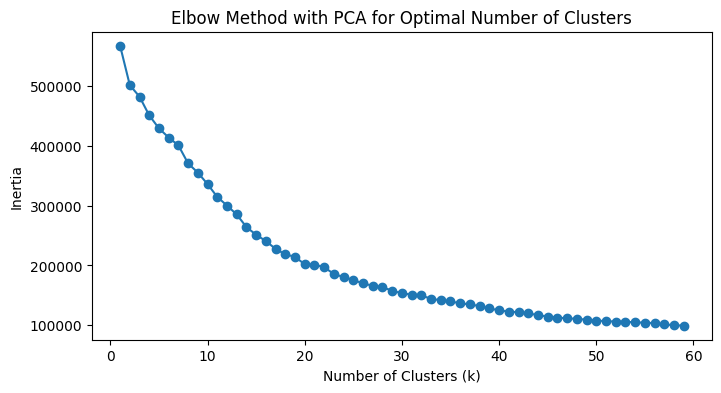

In [16]:
X_transformed = preprocessor.fit_transform(df)

pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_transformed)

inertia = []
k_range = range(1, 60)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method with PCA for Optimal Number of Clusters')
plt.show()

In [17]:
features = df.columns.to_list()
cluster_labels = df.columns.to_frame()

In [18]:
explained_variance = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance)

print("Explained Variance Ratio per Component:")
print(explained_variance)

print("\nCumulative Explained Variance:")
print(cumulative_variance)

Explained Variance Ratio per Component:
[0.14338097 0.05943692 0.05019534 0.04572562 0.03741826 0.03427423
 0.03280523 0.03229904 0.03099542 0.03043017 0.03004604 0.02991906
 0.02983816 0.02965473 0.02925909 0.02860334 0.02698871 0.02656898
 0.02593725 0.02556781]

Cumulative Explained Variance:
[0.14338097 0.2028179  0.25301324 0.29873886 0.33615712 0.37043135
 0.40323658 0.43553562 0.46653105 0.49696121 0.52700725 0.55692631
 0.58676447 0.61641921 0.64567829 0.67428164 0.70127035 0.72783933
 0.75377658 0.77934439]


In [19]:
df.to_excel('clusters.xlsx')

In [20]:
df['profit'] = df['total_sales_price'] - df['cost']

cluster_counts = df['cluster'].value_counts().to_frame()
cluster_avg_profit = df['profit'].groupby(df['cluster']).mean().to_frame(name='average profit')
cluster_avg_adults = df['adults'].groupby(df['cluster']).mean().to_frame(name='average adults')
cluster_avg_children = df['children'].groupby(df['cluster']).mean().to_frame(name='average children')
cluster_avg_vip_qty = df['VIP'].groupby(df['cluster']).mean().to_frame(name='average vip qty')
cluster_avg_bag_qty = df['baggage'].groupby(df['cluster']).mean().to_frame(name='average baggage qty')
cluster_avg_seat_1_15_qty = df['seat_1_15'].groupby(df['cluster']).mean().to_frame(name='average seat_1_15 qty')
cluster_avg_seat_16_25_qty = df['seat_16_25'].groupby(df['cluster']).mean().to_frame(name='average seat_16_25 qty')
cluster_avg_seat_26plus_qty = df['seat_26plus'].groupby(df['cluster']).mean().to_frame(name='average seat_26plus qty')
cluster_avg_num_legs = df['num_legs'].groupby(df['cluster']).mean().to_frame(name='average num legs')

cluster_stats = pd.concat([cluster_counts, cluster_avg_profit, cluster_avg_adults, cluster_avg_children, cluster_avg_vip_qty, cluster_avg_bag_qty, cluster_avg_seat_1_15_qty, cluster_avg_seat_16_25_qty, cluster_avg_seat_26plus_qty, cluster_avg_num_legs], axis=1)

In [21]:
cluster_stats.to_excel('cluster_stats.xlsx')

In [ ]:
columns_to_compute = {
    'profit': 'perc_profitable',
    'children': 'perc_children',
    'VIP': 'perc_VIP',
    'baggage': 'perc_baggage',
    'seat_1_15': 'perc_seat_1_15',
    'seat_16_25': 'perc_seat_16_25',
    'seat_26plus': 'perc_seat_26plus',
}

cluster_percentage_stats = df.groupby('cluster').apply(
    lambda group: pd.Series({
        'count': len(group),
        **{new_name: (group[col] > 0).mean() * 100 for col, new_name in columns_to_compute.items()}
    })
)

cluster_percentage_stats = cluster_percentage_stats.reset_index()


/var/folders/gq/50zq6n4d3vl2rcjc5w22qs5w0000gn/T/ipykernel_59004/3473063458.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_percentage_stats = df.groupby('cluster').apply(


In [23]:
cluster_percentage_stats.to_excel('cluster_perc_stats.xlsx')

In [24]:
cluster_stats.join(cluster_percentage_stats.drop(columns='count'), on='cluster')

,count,average profit,average adults,average children,average vip qty,average baggage qty,average seat_1_15 qty,average seat_16_25 qty,average seat_26plus qty,average num legs,cluster,perc_profitable,perc_children,perc_VIP,perc_baggage,perc_seat_1_15,perc_seat_16_25,perc_seat_26plus
cluster,,,,,,,,,,,,,,,,,,
0,5729,-29.164057,1.282423,0.021819,0.147670,0.105952,0.055682,0.000000,0.000000,1.562576,0,28.137546,2.146972,11.659976,7.697678,1.675685,0.000000,0.000000
9,3858,104.559119,1.166926,0.011664,0.233541,0.377657,0.059616,0.000000,0.000000,2.029808,9,56.428201,1.088647,19.103162,19.206843,1.762571,0.000000,0.000000
4,3285,9.595837,1.141553,0.138204,0.125419,0.182344,0.008524,0.000000,0.000000,1.045967,4,41.278539,10.106545,9.680365,15.829528,0.639269,0.000000,0.000000
10,2580,358.210828,1.779457,0.054264,0.800775,0.101938,0.067054,0.000388,0.000000,2.332558,10,62.480620,4.922481,45.620155,4.961240,1.395349,0.038760,0.000000
18,2210,347.638134,1.395928,0.043891,0.819457,0.327149,0.150679,0.000000,0.000000,1.870588,18,80.588235,3.619910,55.384615,18.054299,3.755656,0.000000,0.000000
21,1057,522.314540,2.759697,0.526017,1.955535,0.139073,0.081362,0.000000,0.000000,2.244087,21,56.291391,35.572375,62.346263,4.446547,1.229896,0.000000,0.000000
1,1002,388.179547,3.106786,0.663673,1.262475,3.202595,0.578842,0.032934,0.000000,1.905190,1,70.159681,40.419162,35.129741,73.552894,6.187625,1.397206,0.000000
16,866,344.457929,1.489607,0.035797,0.406467,0.383372,0.000000,0.000000,0.000000,1.934180,16,91.801386,3.348730,23.787529,17.667436,0.000000,0.000000,0.000000
2,319,207.032321,1.746082,0.144201,1.235110,0.178683,1.178683,0.012539,0.000000,1.952978,2,99.059561,9.717868,67.084639,11.285266,23.197492,1.253918,0.000000


In [27]:
cluster_stats.to_excel('cluster_stats.xlsx')

/var/folders/gq/50zq6n4d3vl2rcjc5w22qs5w0000gn/T/ipykernel_59004/3871723018.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top5_pairings['pair'], rotation=45, ha='right')
/var/folders/gq/50zq6n4d3vl2rcjc5w22qs5w0000gn/T/ipykernel_59004/3871723018.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top5_pairings['pair'], rotation=45, ha='right')
/var/folders/gq/50zq6n4d3vl2rcjc5w22qs5w0000gn/T/ipykernel_59004/3871723018.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top5_pairings['pair'], rotation=45, ha='right')
/var/folders/gq/50zq6n4d3vl2rcjc5w22qs5w0000gn/T/ipykernel_59004/3871723018.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of tick

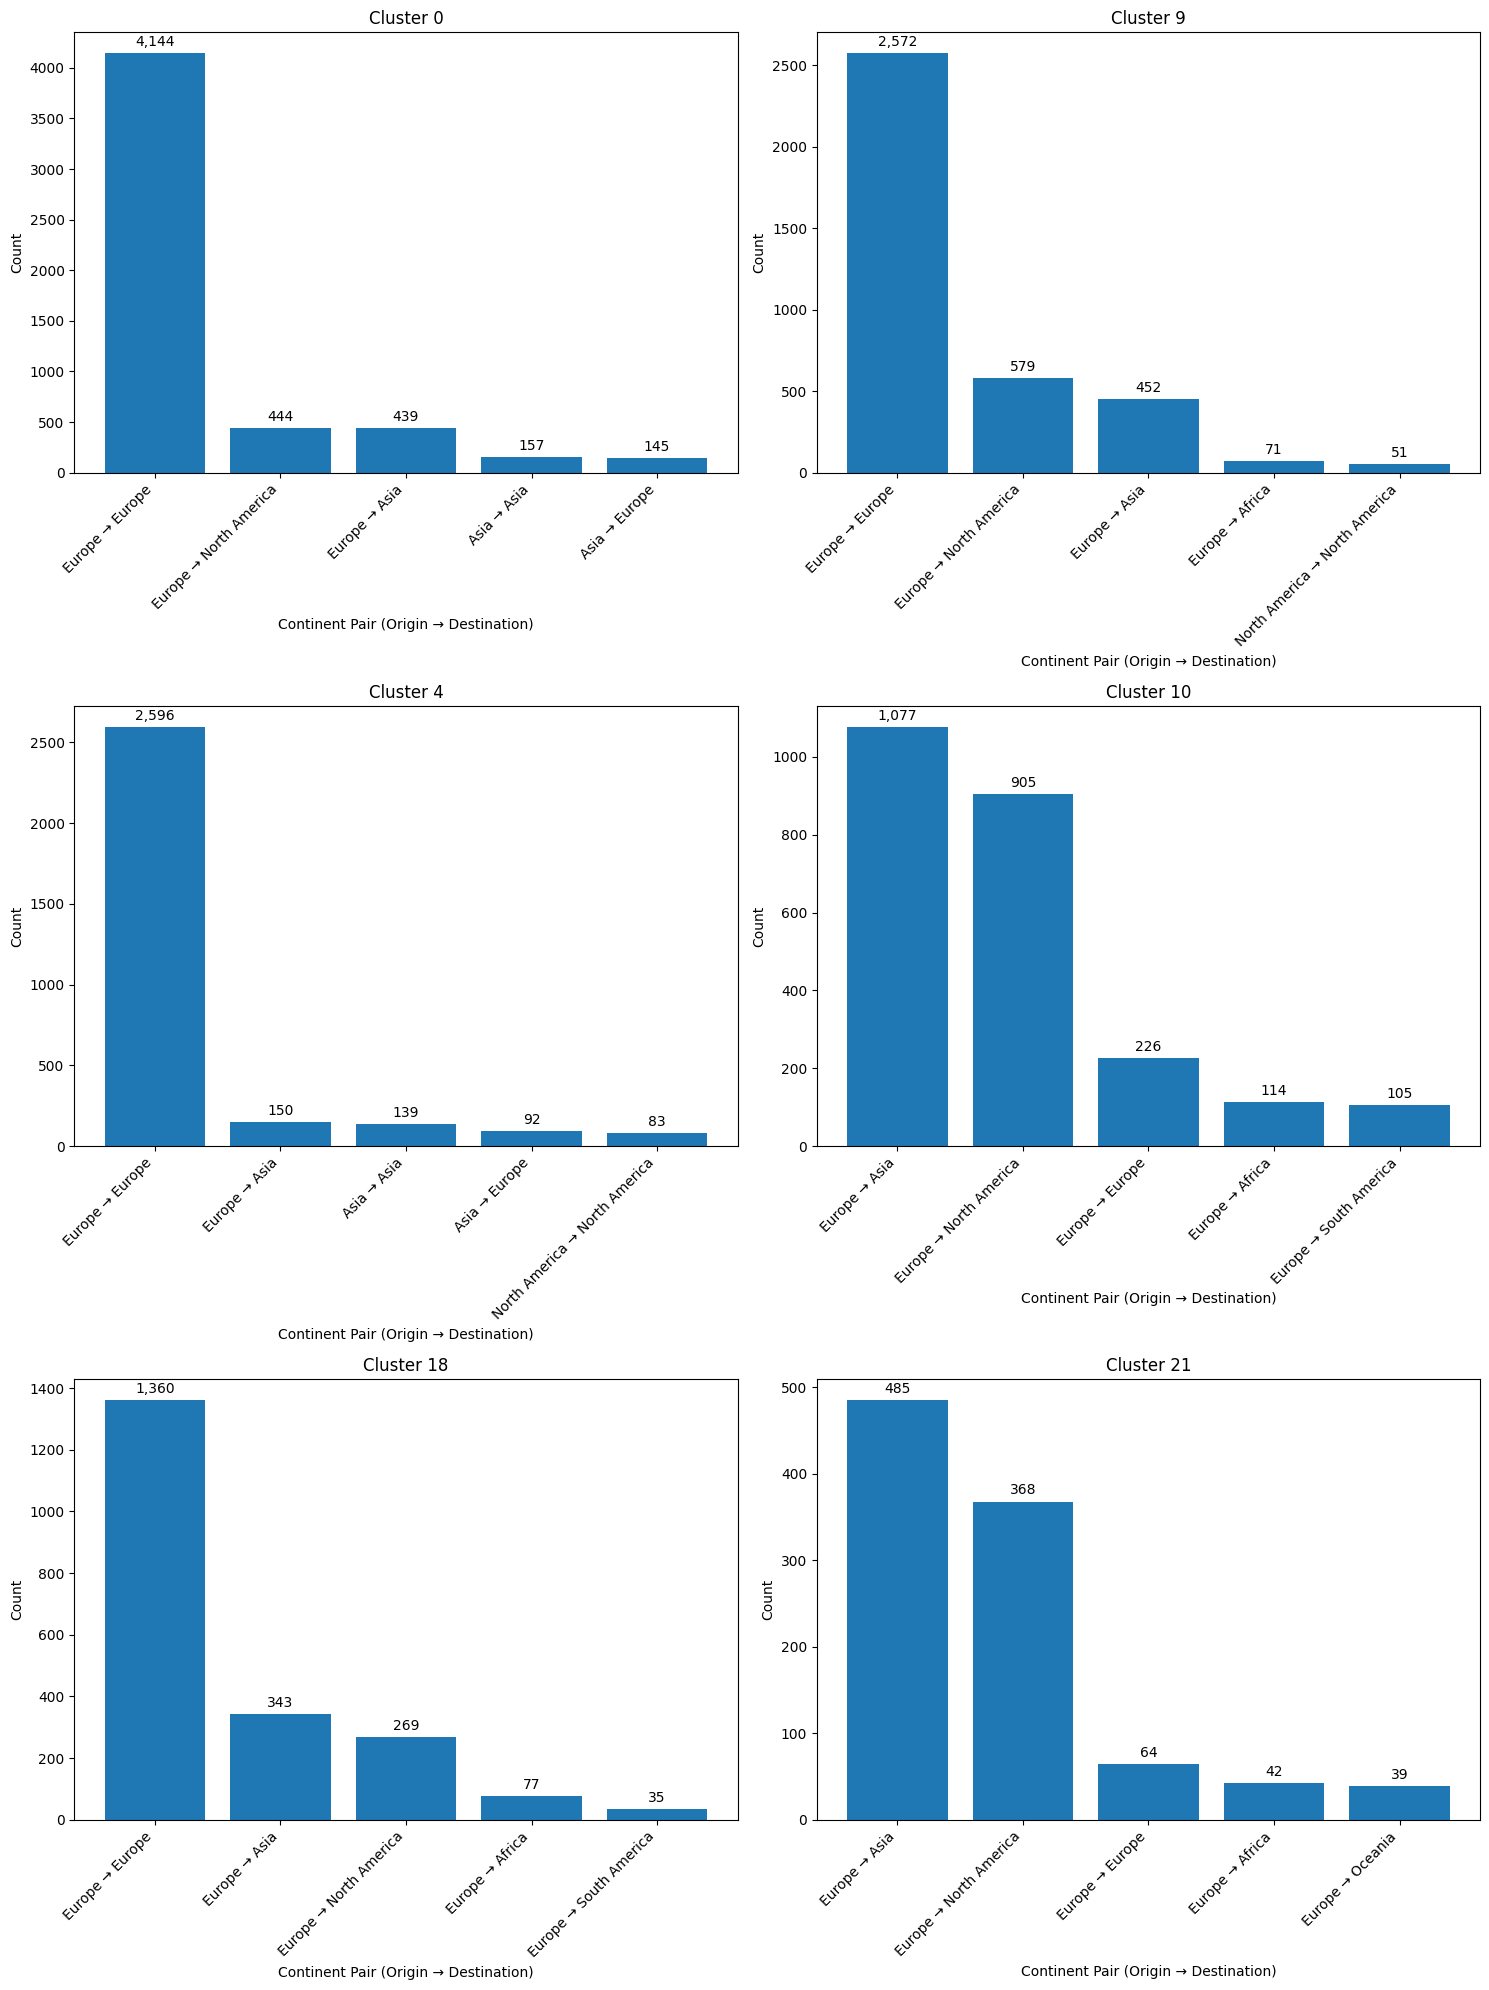

In [63]:

clusters = [0, 9, 4, 10, 18, 21]

ncols = 3
nrows = 2

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))
axes = axes.flatten()

for i, cluster in enumerate(clusters):
    ax = axes[i]
    cluster_df = df[df['cluster'] == cluster]
    
    continent_cols = ['leg_0_origin_continent', 'leg_0_destination_continent']
    pairings = cluster_df.groupby(continent_cols).size().reset_index(name='count')
    
    pairings['pair'] = pairings['leg_0_origin_continent'] + " → " + pairings['leg_0_destination_continent']
    
    top5_pairings = pairings.sort_values(by='count', ascending=False).head(5)
    
    bars = ax.bar(top5_pairings['pair'], top5_pairings['count'])
    ax.set_xlabel("Continent Pair (Origin → Destination)")
    ax.set_ylabel("Count")
    ax.set_title(f"Cluster {cluster}")
    ax.set_xticklabels(top5_pairings['pair'], rotation=45, ha='right')
    
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()
